In [117]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import os
import PIL
%matplotlib inline

In [118]:
batch_size = 40
img_height = 200
img_width = 200

Keras dataset preprocessing utilities, located at tf.keras.preprocessing, help you go from raw data on disk to a tf.data.Dataset object that can be used to train a model.

See https://keras.io/api/preprocessing/

Once the dataset is preprocessed and loaded, it can be directly used in calls to model.fit



In [119]:
## loading training data
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset= "training",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [120]:
## loading testing data
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
'data',
    validation_split=0.2,
    subset= "validation",
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [121]:
print(training_ds)
print(testing_ds)

<BatchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>


In [108]:
class_names = training_ds.class_names

In [123]:
training_labels = training_ds.class_names
testing_labels = testing_ds.class_names

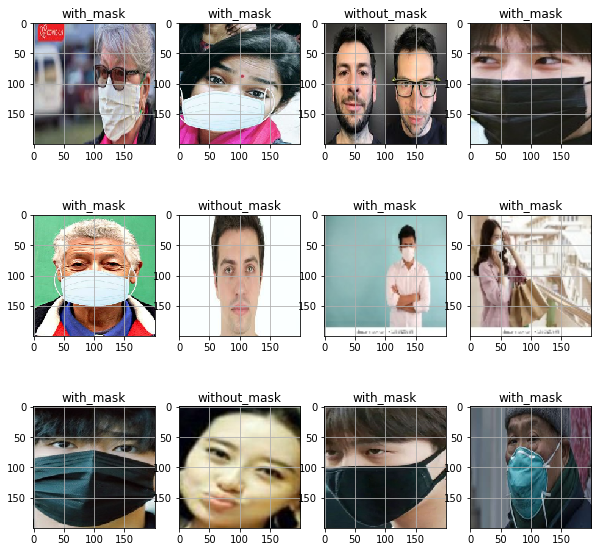

In [110]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.grid(True)

TypeError: only integer scalar arrays can be converted to a scalar index

In [111]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Now build a deep neural network and train it and see how you do

In [40]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
history = model.fit(
  training_ds,
  validation_data=testing_ds,
  epochs=10
)

Epoch 1/10
152/152 [==============================] - 189s 1s/step - loss: 0.2499 - accuracy: 0.9017 - val_loss: 0.2846 - val_accuracy: 0.8861
Epoch 2/10
152/152 [==============================] - 148s 975ms/step - loss: 0.2056 - accuracy: 0.9239 - val_loss: 0.2571 - val_accuracy: 0.8974
Epoch 3/10
152/152 [==============================] - 142s 931ms/step - loss: 0.1552 - accuracy: 0.9437 - val_loss: 0.1654 - val_accuracy: 0.9377
Epoch 4/10
152/152 [==============================] - 140s 924ms/step - loss: 0.1261 - accuracy: 0.9532 - val_loss: 0.1990 - val_accuracy: 0.9272
Epoch 5/10
152/152 [==============================] - 144s 946ms/step - loss: 0.0852 - accuracy: 0.9709 - val_loss: 0.1707 - val_accuracy: 0.9331
Epoch 6/10
152/152 [==============================] - 606s 4s/step - loss: 0.0729 - accuracy: 0.9753 - val_loss: 0.2793 - val_accuracy: 0.9192
Epoch 7/10
152/152 [==============================] - 157s 1s/step - loss: 0.0600 - accuracy: 0.9790 - val_loss: 0.2067 - val_accu

In [57]:
mask_url = "https://media.vanityfair.com/photos/5f2ac1b683d239dce41f8229/master/pass/kate-middleton.jpg"
mask_path = tf.keras.utils.get_file('kate mask', origin=mask_url)

img = keras.preprocessing.image.load_img(
    mask_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 99.96 percent confidence.


In [58]:
nomask_url = "https://www.bostonherald.com/wp-content/uploads/2020/04/baker08.jpg"
nomask_path = tf.keras.utils.get_file('no_mask', origin=nomask_url)

img = keras.preprocessing.image.load_img(
    nomask_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to without_mask with a 94.88 percent confidence.


In [59]:
cosmo_url = "https://upload.wikimedia.org/wikipedia/commons/e/ea/Cosmo_the_Cougar.jpg"
cosmo_path = tf.keras.utils.get_file('cosmo', origin=cosmo_url)

img = keras.preprocessing.image.load_img(
    cosmo_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 100.00 percent confidence.


In [60]:
pink_url = "https://cdn.shopify.com/s/files/1/2727/4444/products/E42A9819.jpg?v=1586730354"
pink_path = tf.keras.utils.get_file('pink', origin=pink_url)

img = keras.preprocessing.image.load_img(
    pink_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 100.00 percent confidence.


In [61]:
group_url = "https://www.wabe.org/wp-content/uploads/2020/04/IMG_3390-e1586270093457-710x355.jpg"
group_path = tf.keras.utils.get_file('group', origin=group_url)

img = keras.preprocessing.image.load_img(
    group_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 100.00 percent confidence.


In [62]:
group_no_url = "https://theanswerclass.com/wp-content/uploads/2018/02/bigstock-Happy-Group-Of-People-3928383-2-1-scaled.jpg"
group_no_path = tf.keras.utils.get_file('group_no', origin=group_no_url)

img = keras.preprocessing.image.load_img(
    group_no_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 100.00 percent confidence.


In [63]:
nomask2_url = "https://images.news.iu.edu/dams/ngeskt3qtg_actual.jpg"
nomask2_path = tf.keras.utils.get_file('nomask2', origin=nomask2_url)

img = keras.preprocessing.image.load_img(
    nomask2_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

991232/987793 [==============================] - 2s 2us/step
This image most likely belongs to without_mask with a 99.99 percent confidence.


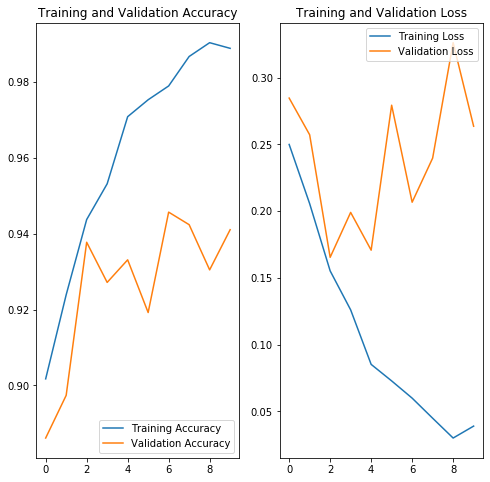

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data Augmentation

In [66]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Dropout

In [67]:
model2 = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [69]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [71]:
history = model2.fit(
  training_ds,
  validation_data=testing_ds,
  epochs=10
)

Epoch 1/10
152/152 [==============================] - 182s 1s/step - loss: 0.4189 - accuracy: 0.8183 - val_loss: 0.3085 - val_accuracy: 0.8768
Epoch 2/10
152/152 [==============================] - 163s 1s/step - loss: 0.2702 - accuracy: 0.8890 - val_loss: 0.2257 - val_accuracy: 0.9113
Epoch 3/10
152/152 [==============================] - 159s 1s/step - loss: 0.2382 - accuracy: 0.9075 - val_loss: 0.1957 - val_accuracy: 0.9205
Epoch 4/10
152/152 [==============================] - 174s 1s/step - loss: 0.2183 - accuracy: 0.9141 - val_loss: 0.1694 - val_accuracy: 0.9391
Epoch 5/10
152/152 [==============================] - 154s 1s/step - loss: 0.1956 - accuracy: 0.9255 - val_loss: 0.1529 - val_accuracy: 0.9417
Epoch 6/10
152/152 [==============================] - 236s 2s/step - loss: 0.1855 - accuracy: 0.9313 - val_loss: 0.1521 - val_accuracy: 0.9437
Epoch 7/10
152/152 [==============================] - 306s 2s/step - loss: 0.1689 - accuracy: 0.9353 - val_loss: 0.1339 - val_accuracy: 0.9477

In [75]:
img = keras.preprocessing.image.load_img(
    nomask2_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to without_mask with a 99.91 percent confidence.


In [76]:
img = keras.preprocessing.image.load_img(
    group_no_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 82.73 percent confidence.


In [77]:
img = keras.preprocessing.image.load_img(
    group_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 79.84 percent confidence.


In [83]:
img = keras.preprocessing.image.load_img(
    pink_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 97.34 percent confidence.


In [82]:
img = keras.preprocessing.image.load_img(
    cosmo_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 78.41 percent confidence.


In [81]:
img = keras.preprocessing.image.load_img(
    mask_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to with_mask with a 86.89 percent confidence.


In [84]:
img = keras.preprocessing.image.load_img(
    nomask_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to without_mask with a 55.14 percent confidence.


In [86]:
trump_url = "https://static.politico.com/dims4/default/0b4104a/2147483647/resize/1160x%3E/quality/90/?url=https%3A%2F%2Fstatic.politico.com%2F30%2F77%2Fa140563649a2abe9b2365547e182%2Fap20316609887776-1.jpg"
trump_path = tf.keras.utils.get_file('trump', origin=trump_url)

img = keras.preprocessing.image.load_img(
    trump_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to without_mask with a 60.10 percent confidence.


In [94]:
obama2_url = "https://www.biography.com/.image/t_share/MTE4MDAzNDEwNzg5ODI4MTEw/barack-obama-12782369-1-402.jpg"
obama2_path = tf.keras.utils.get_file('obama2', origin=obama2_url)

img = keras.preprocessing.image.load_img(
    obama2_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to without_mask with a 99.11 percent confidence.


In [140]:
predictions = model2.predict(testing_ds)
predicted_classes = np.argmax(predictions, axis=1) 
print(predicted_classes)

[0 1 1 ... 0 0 1]


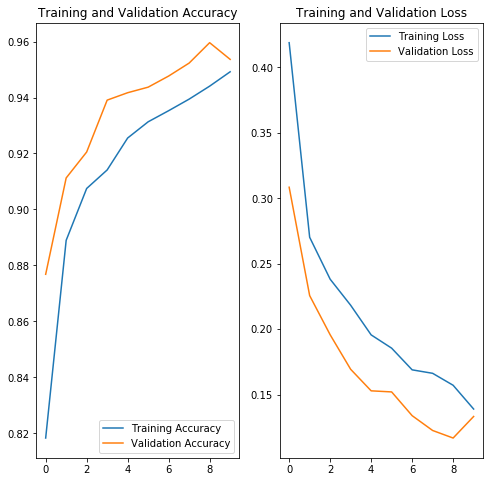

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()